## Download Dataset

In [9]:
import os
import gdown

# Safer, cross-platform path building
output_dir = os.path.join("data", "phase1")
output_zip = os.path.join(output_dir, "dlav_train.zip")

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

if not os.path.exists(output_zip):
    print("Downloading data...")

In [10]:
# Install gdown to handle Google Drive file download
!pip install -q gdown
import os
import gdown
import zipfile

download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_dir = os.path.join("data", "phase1")
output_zip = os.path.join(output_dir, "dlav_train.zip")


if not os.path.exists(output_zip):  # Check if the file already exists
    gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
if not os.path.exists(os.path.join(output_dir, "train")):  # Check if the directory already exists    
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
        zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu"
output_zip = os.path.join(output_dir, "dlav_val.zip")

if not os.path.exists(output_zip):  # Check if the file already exists
    gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
if not os.path.exists(os.path.join(output_dir, "val")):  # Check if the directory already exists
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
        zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV"
output_zip = os.path.join(output_dir, "dlav_test_public.zip")

if not os.path.exists(output_zip):  # Check if the file already exists
    gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
if not os.path.exists(os.path.join(output_dir, "test_public")):  # Check if the directory already exists
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
        zip_ref.extractall(".")

## Dataset Class


In [11]:
import torch
from torch.utils.data import Dataset
import pickle

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load pickle file
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        # Convert numpy arrays to tensors
        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1)/255.0
        history = torch.FloatTensor(data['sdc_history_feature'])
        
        if not self.test:
          future = torch.FloatTensor(data['sdc_future_feature'])
          return {
            'camera': camera,
            'history': history,
            'future': future
          }
        else:
          return {
            'camera': camera,
            'history': history
          }

## Data Augmentation

In [12]:
import os
import random
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tqdm import tqdm

def augment_and_save(file_list, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    new_files = []

    for file_path in tqdm(file_list):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        # Flip image horizontally
        camera = data['camera'][:, ::-1, :]  # shape HxWxC, flip width

        # Flip signs for 2nd and 3rd cols in history and future
        data['camera'] = camera
        data['sdc_history_feature'][:, 1:] *= -1

        if 'sdc_future_feature' in data:
            data['sdc_future_feature'][:, 1:] *= -1

        # Save to new file
        base = os.path.basename(file_path)
        new_path = os.path.join(save_dir, f"flipped_{base}")
        with open(new_path, 'wb') as f:
            pickle.dump(data, f)

        new_files.append(new_path)

    return new_files

if not os.path.exists(os.path.join('data', 'phase1', 'augmented_train')):
    train_data_dir = os.path.join('data', 'phase1', 'train')
    train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
    augmented_train = augment_and_save(train_files, save_dir=os.path.join('data', 'phase1', 'augmented_train'))
else:
    print("Augmented training data already exists. Skipping augmentation.")



Augmented training data already exists. Skipping augmentation.


### Augmented data visualization

Loaded 639.pkl
Loaded flipped_639.pkl
Loaded 25.pkl
Loaded flipped_25.pkl
Loaded 275.pkl
Loaded flipped_275.pkl
Loaded 223.pkl
Loaded flipped_223.pkl


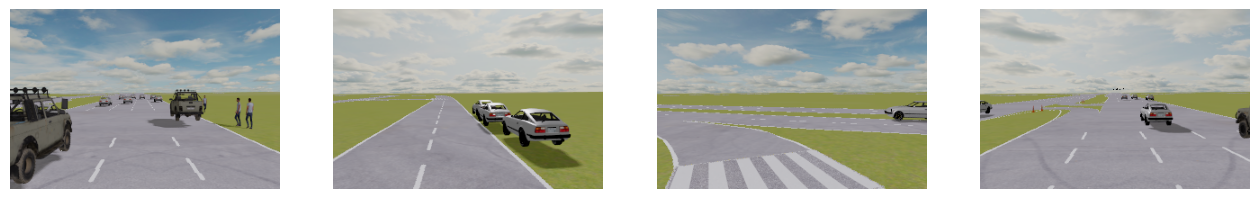

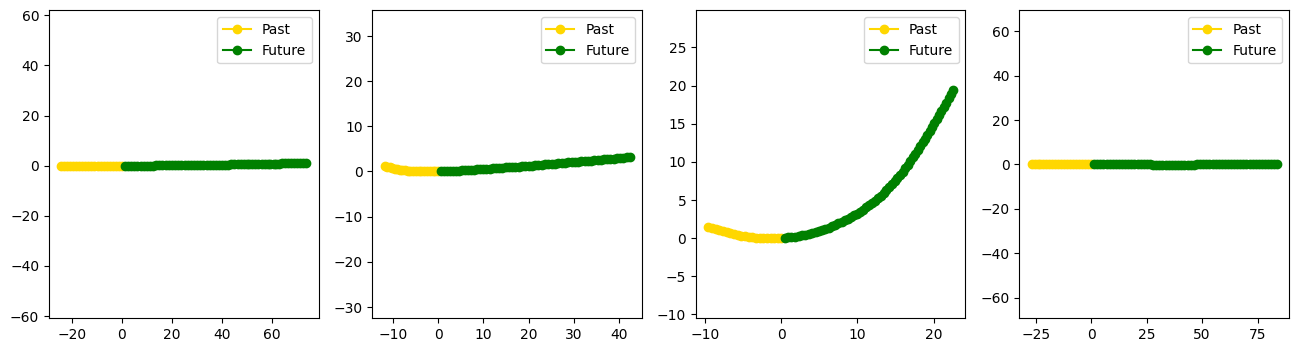

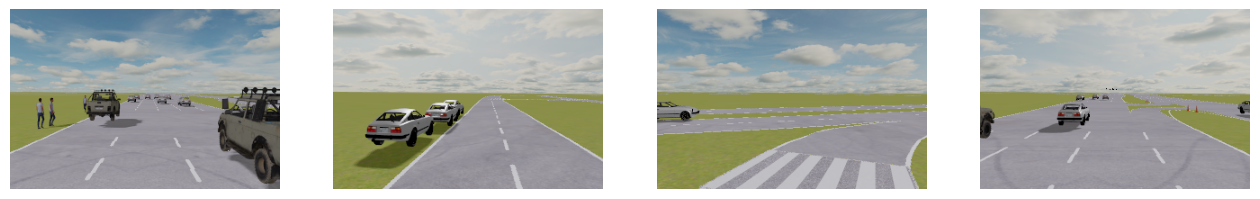

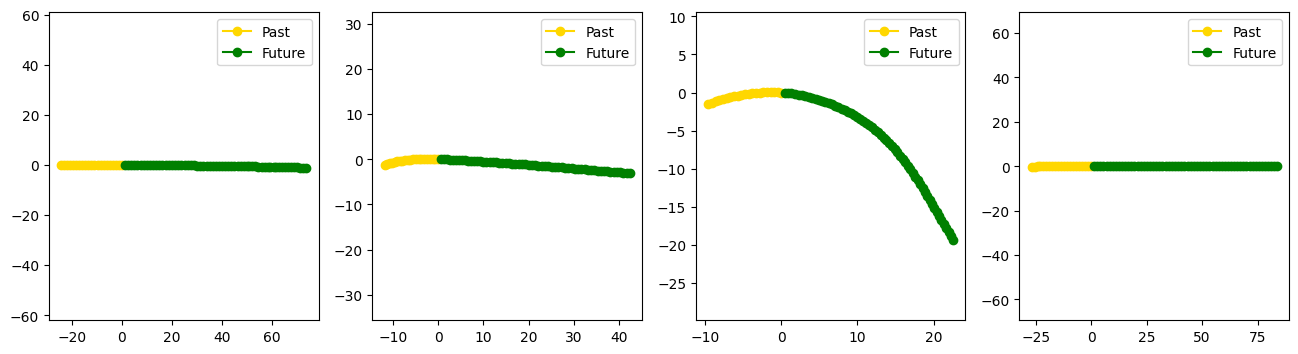

In [13]:
data_dir = os.path.join("data", "phase1")
# Define paths to data
train_data_dir = os.path.join(data_dir, "train")
val_data_dir = os.path.join(data_dir, "val")

# Get file lists
train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]


# Create datasets
train_dataset = DrivingDataset(train_files)
val_dataset = DrivingDataset(val_files)

augmented_train_data_dir = os.path.join(data_dir, "augmented_train")
augmented_train_files = [os.path.join(augmented_train_data_dir, f) for f in os.listdir(augmented_train_data_dir) if f.endswith('.pkl')]

# Create augmented datasets
augmented_train_dataset = DrivingDataset(augmented_train_files)


# load k data from augmented_samples
aug_data = []
data = []
k = 4
# load the data
for i in random.choices(np.arange(1000), k=k):
    with open(f"{train_data_dir}/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))
        print(f"Loaded {i}.pkl")
    with open(f"{augmented_train_data_dir}/flipped_{i}.pkl", "rb") as f:
        aug_data.append(pickle.load(f))
        print(f"Loaded flipped_{i}.pkl")


# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(aug_data[i]["camera"])
    axis[i].axis("off")
plt.show()

fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(aug_data[i]["sdc_history_feature"][:, 0], aug_data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(aug_data[i]["sdc_future_feature"][:, 0], aug_data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()



## Planner

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import pytorch_lightning as pl
import os
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything

import numpy as np

def compute_ade_fde(pred_trajectories, gt_trajectory, include_heading = False, confidences=None):
    """
    Compute Average Displacement Error and Final Displacement Error
    
    Args:
        pred_trajectories: Tensor of shape [B, M, T, 2] where M is number of modes
        gt_trajectory: Tensor of shape [B, T, 2+] (the + indicates there might be more features)
        
    Returns:
        ade: Average Displacement Error across all timesteps
        fde: Final Displacement Error (last timestep only)
    """
    # Extract only x, y coordinates from ground truth if needed
    if include_heading:
        gt_xy = gt_trajectory[..., :3]
    else:
        gt_xy = gt_trajectory[..., :2]
    
    # Calculate per-mode errors
    error_per_mode = torch.norm(pred_trajectories - gt_xy.unsqueeze(1), dim=-1)  # [B, M, T]
    
    # If confidences are provided, use them to select best mode
    if confidences is not None:
        best_mode_idx = confidences.argmax(dim=1)  # [B] - Use highest confidence
    else:
        # Fall back to minimum ADE if no confidences provided
        mode_ade = error_per_mode.mean(dim=2)  # [B, M]
        best_mode_idx = mode_ade.argmin(dim=1)  # [B]
    
    # Get errors for best mode per batch element
    batch_indices = torch.arange(pred_trajectories.size(0), device=pred_trajectories.device)
    best_mode_error = error_per_mode[batch_indices, best_mode_idx]  # [B, T]
    
    # Compute metrics
    ade = best_mode_error.mean().item()
    fde = best_mode_error[:, -1].mean().item()
    
    return ade, fde

class EnhancedDrivingPlanner(nn.Module):
    def __init__(self, num_modes=6, lr=1e-4, future_steps=60, include_heading=False):
        super().__init__()        
        
        self.num_modes = num_modes
        self.future_steps = future_steps
        self.include_heading = include_heading

        # Visual encoder: ResNet18 pretrained
        resnet = models.resnet18(pretrained=True)
        self.visual_encoder = nn.Sequential(*list(resnet.children())[:-2])  # Remove avgpool and fc layers
        self.visual_pool = nn.AdaptiveAvgPool2d((1, 1))  # Pool to (batch, channels, 1, 1)
        self.visual_fc = nn.Linear(512, 256)  # ResNet18 last conv outputs 512 channels

        # History encoder
        self.history_encoder = nn.Sequential(
            nn.Linear(21 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(256 + 128, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU()
        )
        # Trajectory decoder
        # Predict K trajectories + confidence scores
        if include_heading:
            self.trajectory_head = nn.Linear(512, num_modes * future_steps * 3)
        else:
            self.trajectory_head = nn.Linear(512, num_modes * future_steps * 2)  # (x, y) only, no heading
        self.confidence_head = nn.Linear(512, num_modes)  # One confidence score per mode

    def forward(self, camera, history):
        batch_size = camera.size(0)

        # Encode image
        visual_features = self.visual_encoder(camera)  # (B, 512, H', W')
        visual_features = self.visual_pool(visual_features).view(batch_size, -1)  # (B, 512)
        visual_features = self.visual_fc(visual_features)  # (B, 256)

        # Encode history
        history_flat = history.reshape(batch_size, -1)
        history_features = self.history_encoder(history_flat)  # (B, 128)

        # Fuse
        fused = self.fusion(torch.cat([visual_features, history_features], dim=1))  # (B, 512)

        # Predict
        traj = self.trajectory_head(fused)  # (B, num_modes * future_steps * 2)
        if self.include_heading:
            traj = traj.view(batch_size, self.num_modes, self.future_steps, 3)
        else:
            traj = traj.view(batch_size, self.num_modes, self.future_steps, 2)

        conf = self.confidence_head(fused)  # (B, num_modes)
        conf = torch.softmax(conf, dim=-1)  # Confidence scores across modes

        return traj, conf

        
    def compute_loss(self, traj_pred, conf_pred, future):
            if self.include_heading:
                future_expand = future[:, None, :, :3].expand_as(traj_pred)
            else:
                future_expand = future[:, None, :, :2].expand_as(traj_pred)
            # Compute loss for each mode
            loss_per_mode = nn.SmoothL1Loss(reduction='none')(traj_pred, future_expand).mean(dim=[2,3])  # (B, num_modes)
            # Confidence-weighted loss
            weighted_loss = (loss_per_mode * conf_pred).sum(dim=1).mean()
            return weighted_loss
        

    
class LightningSimplifiedDrivingPlanner(pl.LightningModule):
    def __init__(self, lr=1e-4, weight_decay=1e-4, epochs=50, num_modes=6,scheduler_factor=0.95, scheduler_patience=3, include_heading=False):
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.planner = EnhancedDrivingPlanner(num_modes, include_heading=include_heading)
        self.scheduler_factor = scheduler_factor
        self.scheduler_patience = scheduler_patience
        self.include_heading = include_heading
        self.save_hyperparameters()

        print("\n====================================\nModel initialized with parameters:")
        print(f"Learning Rate: {self.lr}")
        print(f"Weight Decay: {self.weight_decay}")
        print(f"Number of Epochs: {self.epochs}")
        print(f"Number of Modes: {num_modes}")
        print(f"Scheduler Factor: {self.scheduler_factor}")
        print(f"Scheduler Patience: {self.scheduler_patience}\n")
        print(f"Include Heading: {include_heading}\n")

    
    def forward(self, camera, history):
        return self.planner(camera, history)
    
    def training_step(self, batch, batch_idx):
        camera = batch['camera']           # [B,3,H,W]
        history = batch['history']         # [B, T, 3]
        future = batch['future']           # [B, T, 3]

        # Forward pass
        pred_trajs, confidences = self(camera, history)
        
        # Compute loss against the ground-truth future
        loss = self.planner.compute_loss(pred_trajs, confidences, future)
        # Log and return
        self.log('train_loss', loss, prog_bar=True)
        return loss

        

    def validation_step(self, batch, batch_idx):
        camera = batch['camera']
        history = batch['history']
        future = batch['future']

        # Forward pass
        pred_trajs, confidences = self(camera, history)
        
        # Compute loss
        loss = self.planner.compute_loss(pred_trajs, confidences, future)
        
        # Compute ADE and FDE
        ade, fde = compute_ade_fde(pred_trajs, future, self.include_heading, confidences)

        # Log validation metrics
        self.log('val_loss', loss, prog_bar=True, sync_dist=True)
        self.log('val_ade', ade, prog_bar=True, sync_dist=True)
        self.log('val_fde', fde, prog_bar=True, sync_dist=True)

        

        return {'val_loss': loss, 'val_ade': ade, 'val_fde': fde}

    def test_step(self, batch, batch_idx):
        # dont't do anything because we don't have the ground truth
        return {}

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )


        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',           # Reduce LR when monitored value stops decreasing
            factor=self.scheduler_factor,           # Multiply LR by this factor
            patience=self.scheduler_patience,           # Number of epochs with no improvement after which LR will be reduced
            min_lr=1e-6,          # Lower bound on the learning rate
            verbose=True
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_ade',
                'interval': 'epoch',
                'frequency': 1,
                'reduce_on_plateau': True  
            }
        }
    
# Training function
def run_experiment(max_epochs=50, num_nodes=6, batch_size=64, lr=1e-4, weight_decay=1e-4, scheduler_factor=0.95, scheduler_patience=3, augment_train=False, augment_val=False, include_heading = False, seed=42, logger_name='simplified_driving_planner_rnn'):
    # Set random seed for reproducibility
    pl.seed_everything(seed)

    # Define paths to data
    train_data_dir = os.path.join("data", "phase1", "train")
    val_data_dir = os.path.join("data", "phase1", "val")
    augmented_train_data_dir = os.path.join("data", "phase1", "augmented_train")
    augmented_val_data_dir = os.path.join("data", "phase1", "augmented_val")

    # Get file lists
    train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
    val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

    augmented_train_files = [os.path.join(augmented_train_data_dir, f) for f in os.listdir(augmented_train_data_dir) if f.endswith('.pkl')]
    augmented_val_files = [os.path.join(augmented_val_data_dir, f) for f in os.listdir(augmented_val_data_dir) if f.endswith('.pkl')]
    
    if augment_train:
        train_dataset = DrivingDataset(train_files + augmented_train_files)
    else:
        train_dataset = DrivingDataset(train_files)

    if augment_val:
        val_dataset = DrivingDataset(val_files + augmented_val_files)
    else:
        val_dataset = DrivingDataset(val_files)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        pin_memory=True
    )

    # Initialize model with Lightning wrapper
    model = LightningSimplifiedDrivingPlanner(lr=lr, weight_decay=weight_decay, epochs= max_epochs, num_modes=num_nodes, scheduler_factor=scheduler_factor, scheduler_patience=scheduler_patience, include_heading=include_heading)

    # Initialize logger
    logger = TensorBoardLogger(save_dir='phase1_lightning_logs', name=logger_name)
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    # Setup checkpoint callback
    # get logger version
    version = logger.version
    # get the current time for unique checkpoint names
    filename = f"driving_planner_version_{version}"
    print(f"Model version: {version}\n====================================\n ")
    # create a directory for the phase1_phase1_phase1_phase1_phase1_phase1_checkpoints
    checkpoint_callback = ModelCheckpoint(
        dirpath='phase1_checkpoints'+f"/{logger_name}/",
        filename= filename + '_{epoch:02d}_{val_ade:.2f}',
        monitor='val_ade',
        mode='min',
        save_top_k=3,
        save_last=True,
        verbose=True
    )

    # Create trainer with limited epochs for quick overfitting test
    trainer = pl.Trainer(
        max_epochs=max_epochs, 
        logger=logger,
        accelerator='auto',  # Automatically select GPU if available
        devices='auto',
        precision=16,  # Use mixed precision
        log_every_n_steps=5,  # Logging freq
        gradient_clip_val=5.0,
        enable_checkpointing=True,  
        callbacks=[checkpoint_callback, lr_monitor],
  
    )

    # Train on the small dataset
    trainer.fit(model, train_loader, val_loader)
    # return best model and validation loader for testing
    best_model_path = checkpoint_callback.best_model_path
    best_model_val_ade = checkpoint_callback.best_model_score
    print(f"Best model val_ade: {best_model_val_ade}\nBest model path: {best_model_path}")
    # Load the best model
    model = LightningSimplifiedDrivingPlanner.load_from_checkpoint(best_model_path)

    # Test the model on the validation set again to be sure
    model.eval()
    trainer.validate(model, val_loader)
    return model, val_loader, best_model_val_ade

## Hyperparameter tuning

In [ ]:
import optuna

study_name = "fine_optuna_trial_with_heading_old_loss"

def objective(trial):
    # Define the hyperparameter search space
    num_nodes = trial.suggest_int("num_nodes", 4, 6)
    max_epochs = trial.suggest_int("max_epochs", 60, 120)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 5e-5)
    scheduler_factor = trial.suggest_float("scheduler_factor", 0.5, 0.95)
    scheduler_patience = trial.suggest_int("scheduler_patience", 2, 10)
    lr = trial.suggest_loguniform("lr", 5e-5, 1e-3)
    # Run your experiment
    model, val_loader, best_model_val_ade = run_experiment(
        lr=lr,
        num_nodes=num_nodes,
        max_epochs=max_epochs,
        weight_decay=weight_decay,
        scheduler_factor=scheduler_factor,
        scheduler_patience=scheduler_patience,
        augment_train=True,
        include_heading=True,
        logger_name=study_name
    )

    # The score Optuna will try to minimize or maximize
    return best_model_val_ade  

# Create the Optuna study
study = optuna.create_study(direction="minimize")  # or "minimize" depending on your metric
study.optimize(objective,  n_trials=10)

# Save the study results
import joblib

joblib.dump(study, os.path.join('phase1_lightning_logs', study_name, 'optuna_study.pkl'))
# Best trial
print("Best trial:")
print(study.best_trial)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:

optuna.visualization.plot_parallel_coordinate(study)


In [ ]:

optuna.visualization.plot_slice(study)

### Manual Run

In [ ]:
model, val_loader, best_model_score = run_experiment(num_nodes=4, max_epochs=117, weight_decay=2.6551679570632748e-06, scheduler_factor=0.7212519748210666, scheduler_patience=5, lr =0.00018518676207528317, augment_train=True, include_heading=False)

In [27]:
checkpoint = "driving_planner_version_68_epoch=107_val_ade=1.55.ckpt"
run_name = "old_checkpoints"
checkpoint_path = os.path.join("phase1_checkpoints", run_name, checkpoint)
model = LightningSimplifiedDrivingPlanner.load_from_checkpoint(checkpoint_path)
model.eval()
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


Model initialized with parameters:
Learning Rate: 0.00018518676207528317
Weight Decay: 2.6551679570632748e-06
Number of Epochs: 117
Number of Modes: 4
Scheduler Factor: 0.7212519748210666
Scheduler Patience: 5

Include Heading: False



## Results

torch.Size([16, 60, 2])
Epoch 0:  25%|██▌       | 40/157 [06:25<18:48,  0.10it/s, v_num=0, train_loss=2.620]


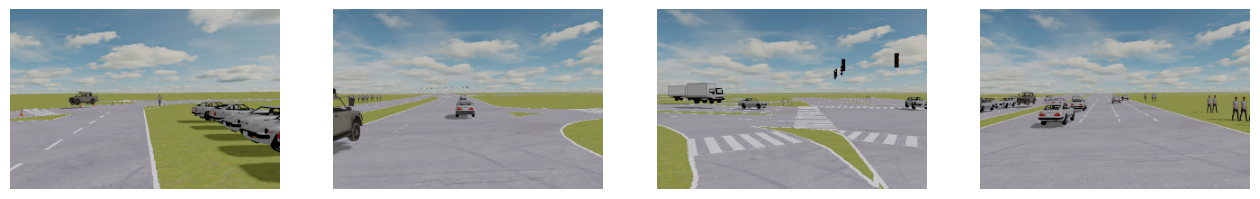

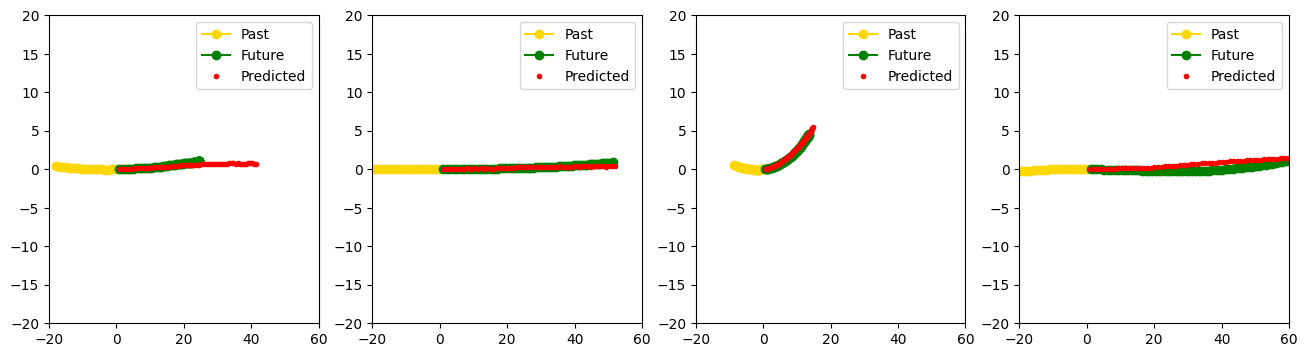

In [29]:
import random
import numpy as np
import matplotlib.pyplot as plt


# Define paths to data
train_data_dir = os.path.join("data", "phase1", "train")
val_data_dir = os.path.join("data", "phase1", "val")
augmented_train_data_dir = os.path.join("data", "phase1", "augmented_train")

# Get file lists
train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

augmented_train_files = [os.path.join(augmented_train_data_dir, f) for f in os.listdir(augmented_train_data_dir) if f.endswith('.pkl')]

if True:
    train_dataset = DrivingDataset(train_files + augmented_train_files)
else:
    train_dataset = DrivingDataset(train_files)


val_dataset = DrivingDataset(val_files)
    
val_loader = DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=False,
        pin_memory=True
    )

val_batch_zero = next(iter(val_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
camera = val_batch_zero['camera'].to(device)
history = val_batch_zero['history'].to(device)
future = val_batch_zero['future'].to(device)

model.eval()
model.to(device)
with torch.no_grad():
    trajectories, confidences = model(camera, history)
            
    # Select the most confident trajectory for each sample
    best_idx = confidences.argmax(dim=1)  # (B,)
    batch_size = trajectories.size(0)
            
    # Use indexing to select the best trajectory for each sample
    pred_future = trajectories[torch.arange(batch_size), best_idx]  # (B, T, 2)
print(pred_future.shape)
camera = camera.cpu().numpy()
history = history.cpu().numpy()
future = future.cpu().numpy()
pred_future = pred_future.cpu().numpy()

k=4
selected_indices = random.choices(np.arange(len(camera)), k=k)
# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].imshow(camera[idx].transpose(1, 2, 0))
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].plot(history[idx, :, 0], history[idx, :, 1], "o-", color="gold", label="Past")
    axis[i].plot(future[idx, :, 0], future[idx, :, 1], "o-", color="green", label="Future")
    axis[i].plot(pred_future[idx, :, 0], pred_future[idx, :, 1], ".", color="red", label="Predicted")
    axis[i].legend()
    axis[i].set_xlim(-20, 60)
    axis[i].set_ylim(-20, 20)
plt.show()

## Test Submission

In [30]:
# Finally make the prediction and keep the trajectory with the highest confidence
import pandas as pd
test_data_dir = os.path.join("data", "phase1", "test_public")
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]

test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# changed form here
model.eval()
all_plans = []

with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)
        
        # Get both trajectories and confidences
        trajectories, confidences = model(camera, history)
        
        # Select the most confident trajectory for each sample
        best_idx = confidences.argmax(dim=1)  # (B,)
        batch_size = trajectories.size(0)
        
        # Use advanced indexing to select the best trajectory for each sample
        best_trajectories = trajectories[torch.arange(batch_size), best_idx]  # (B, T, 2)
        
        all_plans.append(best_trajectories.cpu().numpy())

all_plans = np.concatenate(all_plans, axis=0)
# to here
# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase1_v68_relu_old_loss_aug.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
